# Feature Visualization Tutorial
This notebook serves as a tutorial for how to use the local `feature_vis` python package.

In [1]:
import torch
from torchvision.models import resnet50
from feature_vis.render import FeatureVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Visualizing a neuron in the final, fully-connected layer
Below we visualize the 309th neuron in the fully-connected layer of ResNet-50 (pre-trained on ImageNet).  
This neuron is associated with the "bee" class in ImageNet.

100%|██████████| 256/256 [00:09<00:00, 26.25it/s]


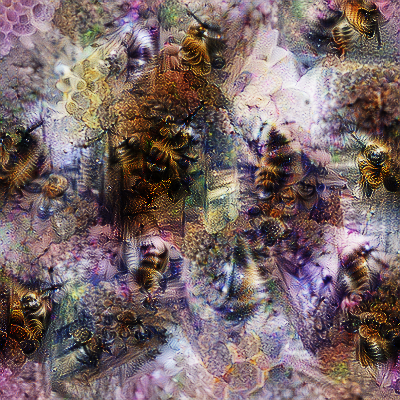

In [2]:
# load a pre-trained model
model = resnet50(pretrained=True)
model.eval()
model.to(device)

# set up the default visualizer object
visualize = FeatureVisualizer(model, device=device)

# create the feature visualization as a PIL image
visualize(act_idx=309)

### Visualizing a hidden channel
In order to visualize an activation from a hidden layer, the model must be sliced such that its output contains the target activation.  
If the output is a volume, then the target activation is the mean of the channel specified by `act_idx`.

100%|██████████| 256/256 [00:05<00:00, 44.82it/s]


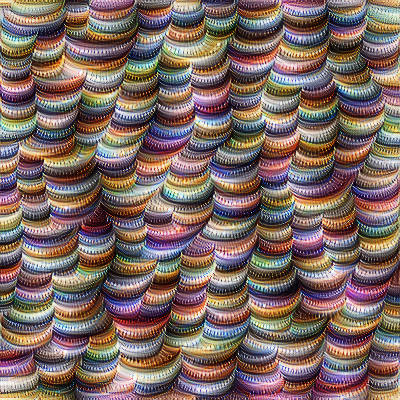

In [3]:
from feature_vis.utils import slice_model

# load a pre-trained model
model = resnet50(pretrained=True)

# slice the model such that the output contains the target activation
model = slice_model(model, 6)
model.eval()
model.to(device)

# set up the default visualizer object
visualize = FeatureVisualizer(model, device=device)

# visualize the mean activation of the 111th channel in the model's output volume
visualize(act_idx=111)

### Visualizing with a pytorch hook
Instead of slicing the network, we can isolate the target activation with pytorch hooks.  
This method is trickier, however it can potentially be more flexible than slicing.

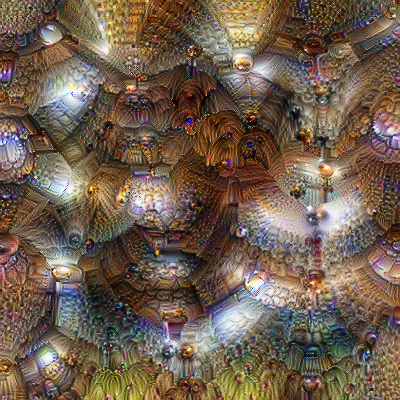

In [4]:
# define a hook which saves the output of a layer as an attribute
def hook(layer, layer_input, layer_output):
    setattr(layer, 'layer_output', layer_output)

# define a custom function which collects the layer_output attribute from a specific component of a module
def collect_layer_output(model):
    return model.layer4[1].conv2.layer_output[0]

# load the pre-trained network
model = resnet50(pretrained=True)
model.eval()
model.to(device)

# register the hook such that the output of layer4, bottleneck1, conv2 is saved as `layer_output` attribute
model.layer4[1].conv2.register_forward_hook(hook)

# set up the visualizer object
visualize = FeatureVisualizer(model, device=device)

# visualize the mean activation of the 50th channel in the output of layer4, bottleneck1, conv2 in ResNet-50
visualize(act_idx=50, hook_output_fn=collect_layer_output, progress=False)

### Creating negative feature visualizations
So far the feature visualizations we have created seek to maximize the target activation. If we instead minimize the target activation, we will create a visualization of the features which the target component in the network does not detect.  
The visualization below contains the negative features for the "bee" class in ImageNet.



100%|██████████| 256/256 [00:09<00:00, 27.82it/s]


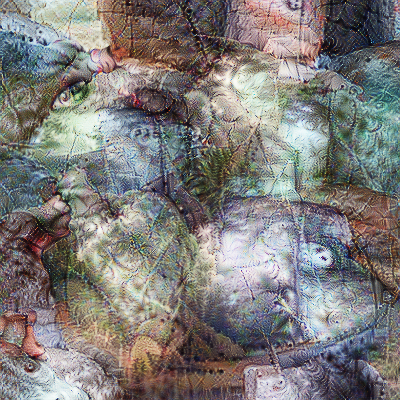

In [5]:
# load a pre-trained model
model = resnet50(pretrained=True)
model.eval()
model.to(device)

# set up the default visualizer object
visualize = FeatureVisualizer(model, device=device)

# create the feature visualization as a PIL image
visualize(act_idx=309, maximize=False)

### Using a custom optimizer
By default, the feature visualizer will use Adam as the optimizer. We can specify a custom optimizer as an argument.  
If doing so, any *args or **kwargs specified in the call will be used as input to the optimizer.

100%|██████████| 256/256 [00:09<00:00, 27.87it/s]


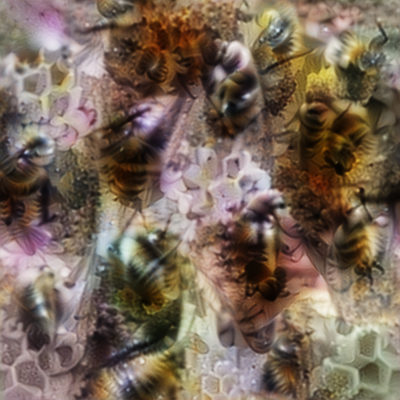

In [6]:
from torch.optim import SGD

# load a pre-trained model
model = resnet50(pretrained=True)
model.eval()
model.to(device)

# set up the visualizer
visualize = FeatureVisualizer(model, device=device)

# create the feature visualization using stochastic gradient descent
# the `momentum` keyword argument is then fed to SGD instance during its initialization
visualize(act_idx=309, optim=SGD, momentum=0.9)

### Other options
Here are some other ways you can configure the FeatureVisualizer:
- the image shape/size
- number of epochs/iterations

100%|██████████| 128/128 [00:02<00:00, 49.58it/s]


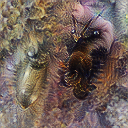

In [7]:
# load a pre-trained model
model = resnet50(pretrained=True)
model.eval()
model.to(device)

# set up the visualizer object
visualize = FeatureVisualizer(model, device=device, img_shape=(128, 128))

# create the feature visualization as a PIL image
visualize(act_idx=309, epochs=128)